# A Jupyter notebook to visualize CLIPSeg-debris predictions

In [ ]:
# !pip install --quiet \
#   "hydra-core" "omegaconf==2.3.0" \
#   "hydra-colorlog>=1.2.0" "colorlog>=6.8,<7" \
#   "lightning==2.4.0" lightning_utilities \
#   openai-clip general_utils==0.1.16 \
#   rootutils==1.0.7 natsort==8.4.0 \
#   "ipywidgets>=8" "gradio>=4"

In [16]:
from huggingface_hub import login, hf_hub_download

# login() # if needed
ckpt_path = hf_hub_download(repo_id="YuhaoL/CLIPSeg-debris", filename="clipseg_debris_weight.ckpt")
print(f"Local path: {ckpt_path}")

Local path: /home/yl241/.cache/huggingface/hub/models--YuhaoL--CLIPSeg-debris/snapshots/4d969eacd395ac32d938e7a0a20d4bd69197dcc5/clipseg_debris_weight.ckpt


In [13]:
import os
import sys
from hydra import compose, initialize
from matplotlib import pyplot as plt
import cv2

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.eval import evaluate

In [19]:
input_dir = "../assets"
prediction_parent_dir = "../experiments/"
output_dir_name = "demo"

# running on CUDA 0
with initialize(version_base=None, config_path="../configs", job_name="test_app"):
    cfg = compose(
        config_name="eval",
        overrides=[f"name={output_dir_name}",
                  "trainer=cpu", # <- toggle between cpu/gpu
                   f"ckpt_path={ckpt_path}",
                   f"data.query_images_dir={input_dir}",
                   f"+local.prediction_output_dir={prediction_parent_dir}"
                   ])

In [20]:
evaluate(cfg); # run evaluation

Seed set to 42
[rank: 0] No logger configs found! Skipping...
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /home/yl241/.cache/huggingface/hub/models--YuhaoL--CLIPSeg-debris/snapshots/4d969eacd395ac32d938e7a0a20d4bd69197dcc5/clipseg_debris_weight.ckpt
Loaded model weights from the checkpoint at /home/yl241/.cache/huggingface/hub/models--YuhaoL--CLIPSeg-debris/snapshots/4d969eacd395ac32d938e7a0a20d4bd69197dcc5/clipseg_debris_weight.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

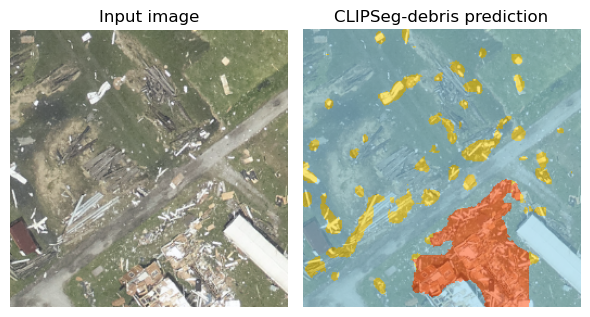

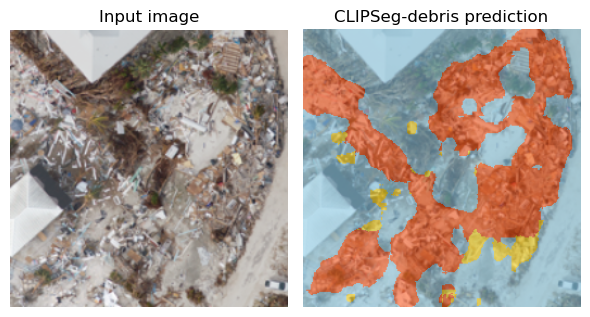

In [22]:
input_images_dir = os.path.join(prediction_parent_dir, output_dir_name, 'original')
prediction_images_dir = os.path.join(prediction_parent_dir, output_dir_name, 'predictions')

input_images = sorted(os.listdir(input_images_dir))
prediction_images = sorted(os.listdir(prediction_images_dir))

for input_img_name, prediction_img_name in zip(input_images, prediction_images):
    input_img_path = os.path.join(input_images_dir, input_img_name)
    prediction_img_path = os.path.join(prediction_images_dir, prediction_img_name)

    input_img = cv2.imread(input_img_path)
    prediction_img = cv2.imread(prediction_img_path)

    fig, axes = plt.subplots(1, 2, figsize=(6, 5))
    axes[0].imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Input image")
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(prediction_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title("CLIPSeg-debris prediction")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()